# Classification

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/305-classification.ipynb)

This notebook contains the simple examples of timeseries classification using ETNA library.

**Table of contents**

* [Classification](#chapter1)  
    * [Loading dataset](#section_1_1)
    * [Feature extraction](#section_1_2)
    * [Cross validation](#section_1_3)
* [Predictability analysis](#chapter2)
    * [Loading dataset](#section_2_1)
    * [Loading pretrained analyzer](#section_2_2)
    * [Analyzing segments predictability](#section_2_3)

In [1]:
!pip install "etna[classification]" -q

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import NaiveModel
from etna.pipeline import Pipeline

## 1. Classification <a class="anchor" id="chapter1"></a>

**Task formulation**: Given the set of time series $\{x_i\}_{i=1}^{N}$ and corresponding labels $\{y_i\}_{i=1}^{N}$ we need to find a classifier that can learn the relationship between time series and label and accurately predict the label of new series.

Our library introduces tools for binary time series classification in experimental format. This implies that the architecture and the API of the objects from `etna.experimental` module might face changes in the future. To use this module, you need to install the corresponding dependencies.  


### 1.1 Loading dataset <a class="anchor" id="section_1_1"></a>

Consider the example `FordA` dataset from [UCR archive](https://www.cs.ucr.edu/~eamonn/time_series_data/). Dataset consists of engine noise measurements and the problem is to diagnose whether a certain symptom exists in the engine.

In [4]:
!curl https://www.cs.ucr.edu/~eamonn/time_series_data_2018/UCRArchive_2018.zip -o data/ucr_datasets.zip
!unzip -q -P someone -j data/ucr_datasets.zip 'UCRArchive_2018/FordA/*.tsv' -d data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  301M  100  301M    0     0  2273k      0  0:02:15  0:02:15 --:--:-- 1504k


In [5]:
def load_ford_a(path: str):
    train_path = path + "_TRAIN.tsv"
    test_path = path + "_TEST.tsv"
    data_train = np.genfromtxt(train_path)
    data_test = np.genfromtxt(test_path)

    X_train, y_train = data_train[:, 1:], data_train[:, 0]
    X_test, y_test = data_test[:, 1:], data_test[:, 0]

    y_train = y_train.astype("int64")
    y_test = y_test.astype("int64")

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = load_ford_a("data/FordA")
y_train[y_train == -1], y_test[y_test == -1] = 0, 0  # transform labels to 0,1

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3601, 500), (1320, 500), (3601,), (1320,))

Let's visualize a sample from each class. 

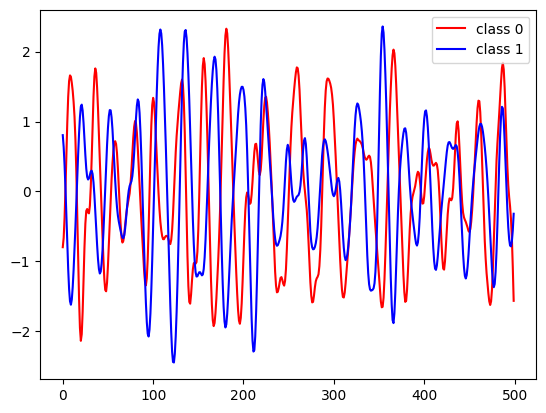

In [8]:
for c in [0, 1]:
    class_samples = X_train[y_train == c]
    plt.plot(class_samples[0], label="class " + str(c), c=["r", "b"][c])
plt.legend(loc="best");

### 1.2 Feature extraction <a class="anchor" id="section_1_2"></a>

Raw time series values are usually not the best features for the classifier. The length of the series is usually much greater than the number of samples in the dataset, in which case classifiers will perform poorly. There are special techniques to extract more informative features from the time series, you can find a comprehensive review of them in this [paper](https://hal.inria.fr/hal-03558165/document).

In our library we offer two methods for feature extraction that can work with the time series of different lengths:

1. `TSFreshFeatureExtractor` &mdash; extract features using `extract_features` method form [tsfresh](https://tsfresh.readthedocs.io/en/latest/).

In [9]:
from etna.experimental.classification.feature_extraction import TSFreshFeatureExtractor

Constructor expects parameters of `extract_features` method, see the full list [here](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html?highlight=feature_extraction#tsfresh.feature_extraction.extraction.extract_features). It also has parameter `fill_na_value` that defines the value for filling the possible NaNs in the generated features.

In [10]:
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters

from etna.experimental.classification.feature_extraction import TSFreshFeatureExtractor

In [11]:
tsfresh_feature_extractor = TSFreshFeatureExtractor(default_fc_parameters=MinimalFCParameters(), fill_na_value=-100)

2. `WEASELFeatureExtractor` &mdash; extract features using the WEASEL algorithm, see the original [paper](https://arxiv.org/pdf/1701.07681.pdf).

This method has a long list of parameters, the most important of them are:

- **padding_value** &mdash; value to pad the series on test set to fit the shortest series in train set
- **word_size**, **n_bins** &mdash; word size and the alphabet size to approximate the series (strongly influence on the performance)
- **window_sizes** &mdash; sizes of the sliding windows
- **window_steps** &mdash; steps of the windows
- **chi2_threshold** &mdash; feature selection threshold (the greter, the fewer features are selected)

In [12]:
from etna.experimental.classification.feature_extraction import WEASELFeatureExtractor

In [13]:
weasel_feature_extractor = feature_extractor = WEASELFeatureExtractor(
    padding_value=-10,
    word_size=4,
    n_bins=4,
    window_sizes=[0.2, 0.3, 0.5, 0.7, 0.9],
    window_steps=[0.1, 0.15, 0.25, 0.35, 0.45],
    chi2_threshold=2,
)

### 1.3 Performance evaluation  <a class="anchor" id="section_1_3"></a>

To evaluate the performance of our feature extraction methods, we will use `masked_crossval_score` method of `TimeSeriesBinaryClassifier`. 

In [14]:
from sklearn.linear_model import LogisticRegression

from etna.experimental.classification import TimeSeriesBinaryClassifier

Firstly, we need to create the instance of `TimeSeriesBinaryClassifier`, which requires setting the feature extractor and the classification model with sklearn interface.

In [15]:
model = LogisticRegression(max_iter=1000)
clf = TimeSeriesBinaryClassifier(feature_extractor=tsfresh_feature_extractor, classifier=model)

Then we need to prepare the fold masks

In [16]:
from sklearn.model_selection import KFold

In [17]:
mask = np.zeros(len(X_train))
for fold_idx, (train_index, test_index) in enumerate(KFold(n_splits=5).split(X_train)):
    mask[test_index] = fold_idx

Then we can run the cross validation and evaluate the performance on 5 folds.

In [18]:
metrics = clf.masked_crossval_score(x=X_train, y=y_train, mask=mask)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 4735.32it/s]


The returned `metrics` dict contains the set of standard classification metrics for each fold:

In [19]:
metrics

{'precision': [0.5336091958066558,
  0.5034126330120741,
  0.5270938738680675,
  0.48479549208199746,
  0.5303571428571429],
 'recall': [0.5294147077387275,
  0.5029400189827997,
  0.5260376744942281,
  0.4855088120003704,
  0.5289386330751553],
 'fscore': [0.515871165705291,
  0.48431786034207236,
  0.5236515337423313,
  0.4796875,
  0.5257560474951779],
 'AUC': [0.5515171107929617,
  0.5507712726964064,
  0.5509333457211654,
  0.5186734158461681,
  0.540038223755987]}

In [20]:
{metric: np.mean(values) for metric, values in metrics.items()}

{'precision': 0.5158536675251876,
 'recall': 0.5145679692582561,
 'fscore': 0.5058568214569745,
 'AUC': 0.5423866737625377}

This feature extraction method shows quite poor quality on this dataset, let's try out the second one.

In [21]:
clf = TimeSeriesBinaryClassifier(feature_extractor=weasel_feature_extractor, classifier=model)
metrics = clf.masked_crossval_score(x=X_train, y=y_train, mask=mask)

In [22]:
metrics

{'precision': [0.8489879944589811,
  0.8737843845512643,
  0.8526994807058697,
  0.865361903806223,
  0.8791666666666667],
 'recall': [0.8490470912421682,
  0.873706507396347,
  0.8539010057371147,
  0.8652350381184604,
  0.8802257832388056],
 'fscore': [0.848819918551392,
  0.8736089168214726,
  0.852640196479738,
  0.8652567241409248,
  0.8790824629033721],
 'AUC': [0.9315568281531427,
  0.9456983895486569,
  0.9298229314256072,
  0.9477144356307293,
  0.9499067618907605]}

In [23]:
{metric: np.mean(values) for metric, values in metrics.items()}

{'precision': 0.864000086037801,
 'recall': 0.8644230851465793,
 'fscore': 0.8638816437793798,
 'AUC': 0.9409398693297794}

As you can see, the feature extraction performance strongly depends on the task domain, so it is a good practice to benchmark several methods on your task.

## 2. Predictability analysis  <a class="anchor" id="chapter2"></a>
**Task formulation**: Given the set of time series $\{x_i\}_{i=1}^{N}$ we need to define whether each of the series can be forecasted with some quality threshold.

This is the extension of the classification task, which helps you to perform some kind of pre-validation on your dataset. This might help to identify the "bad" segments, which should be processed separately.

You can train the `PredictabilityAnalyzer` on your own, however it requires using the dataset consists of the best possible scores for the segments, which might be hard to collect. Therefore, we pretrained several instances of the analyzer on the datasets with `H`, `D` and `W` frequencies.

### 2.1 Loading dataset  <a class="anchor" id="section_2_1"></a>
To demonstrate the usage of this tool, we will use M4 dataset.

In [24]:
from etna.datasets import load_dataset

ts = load_dataset("m4_daily", parts="train")

Let's visualize several random segments from the dataset

Number of segments: 4227


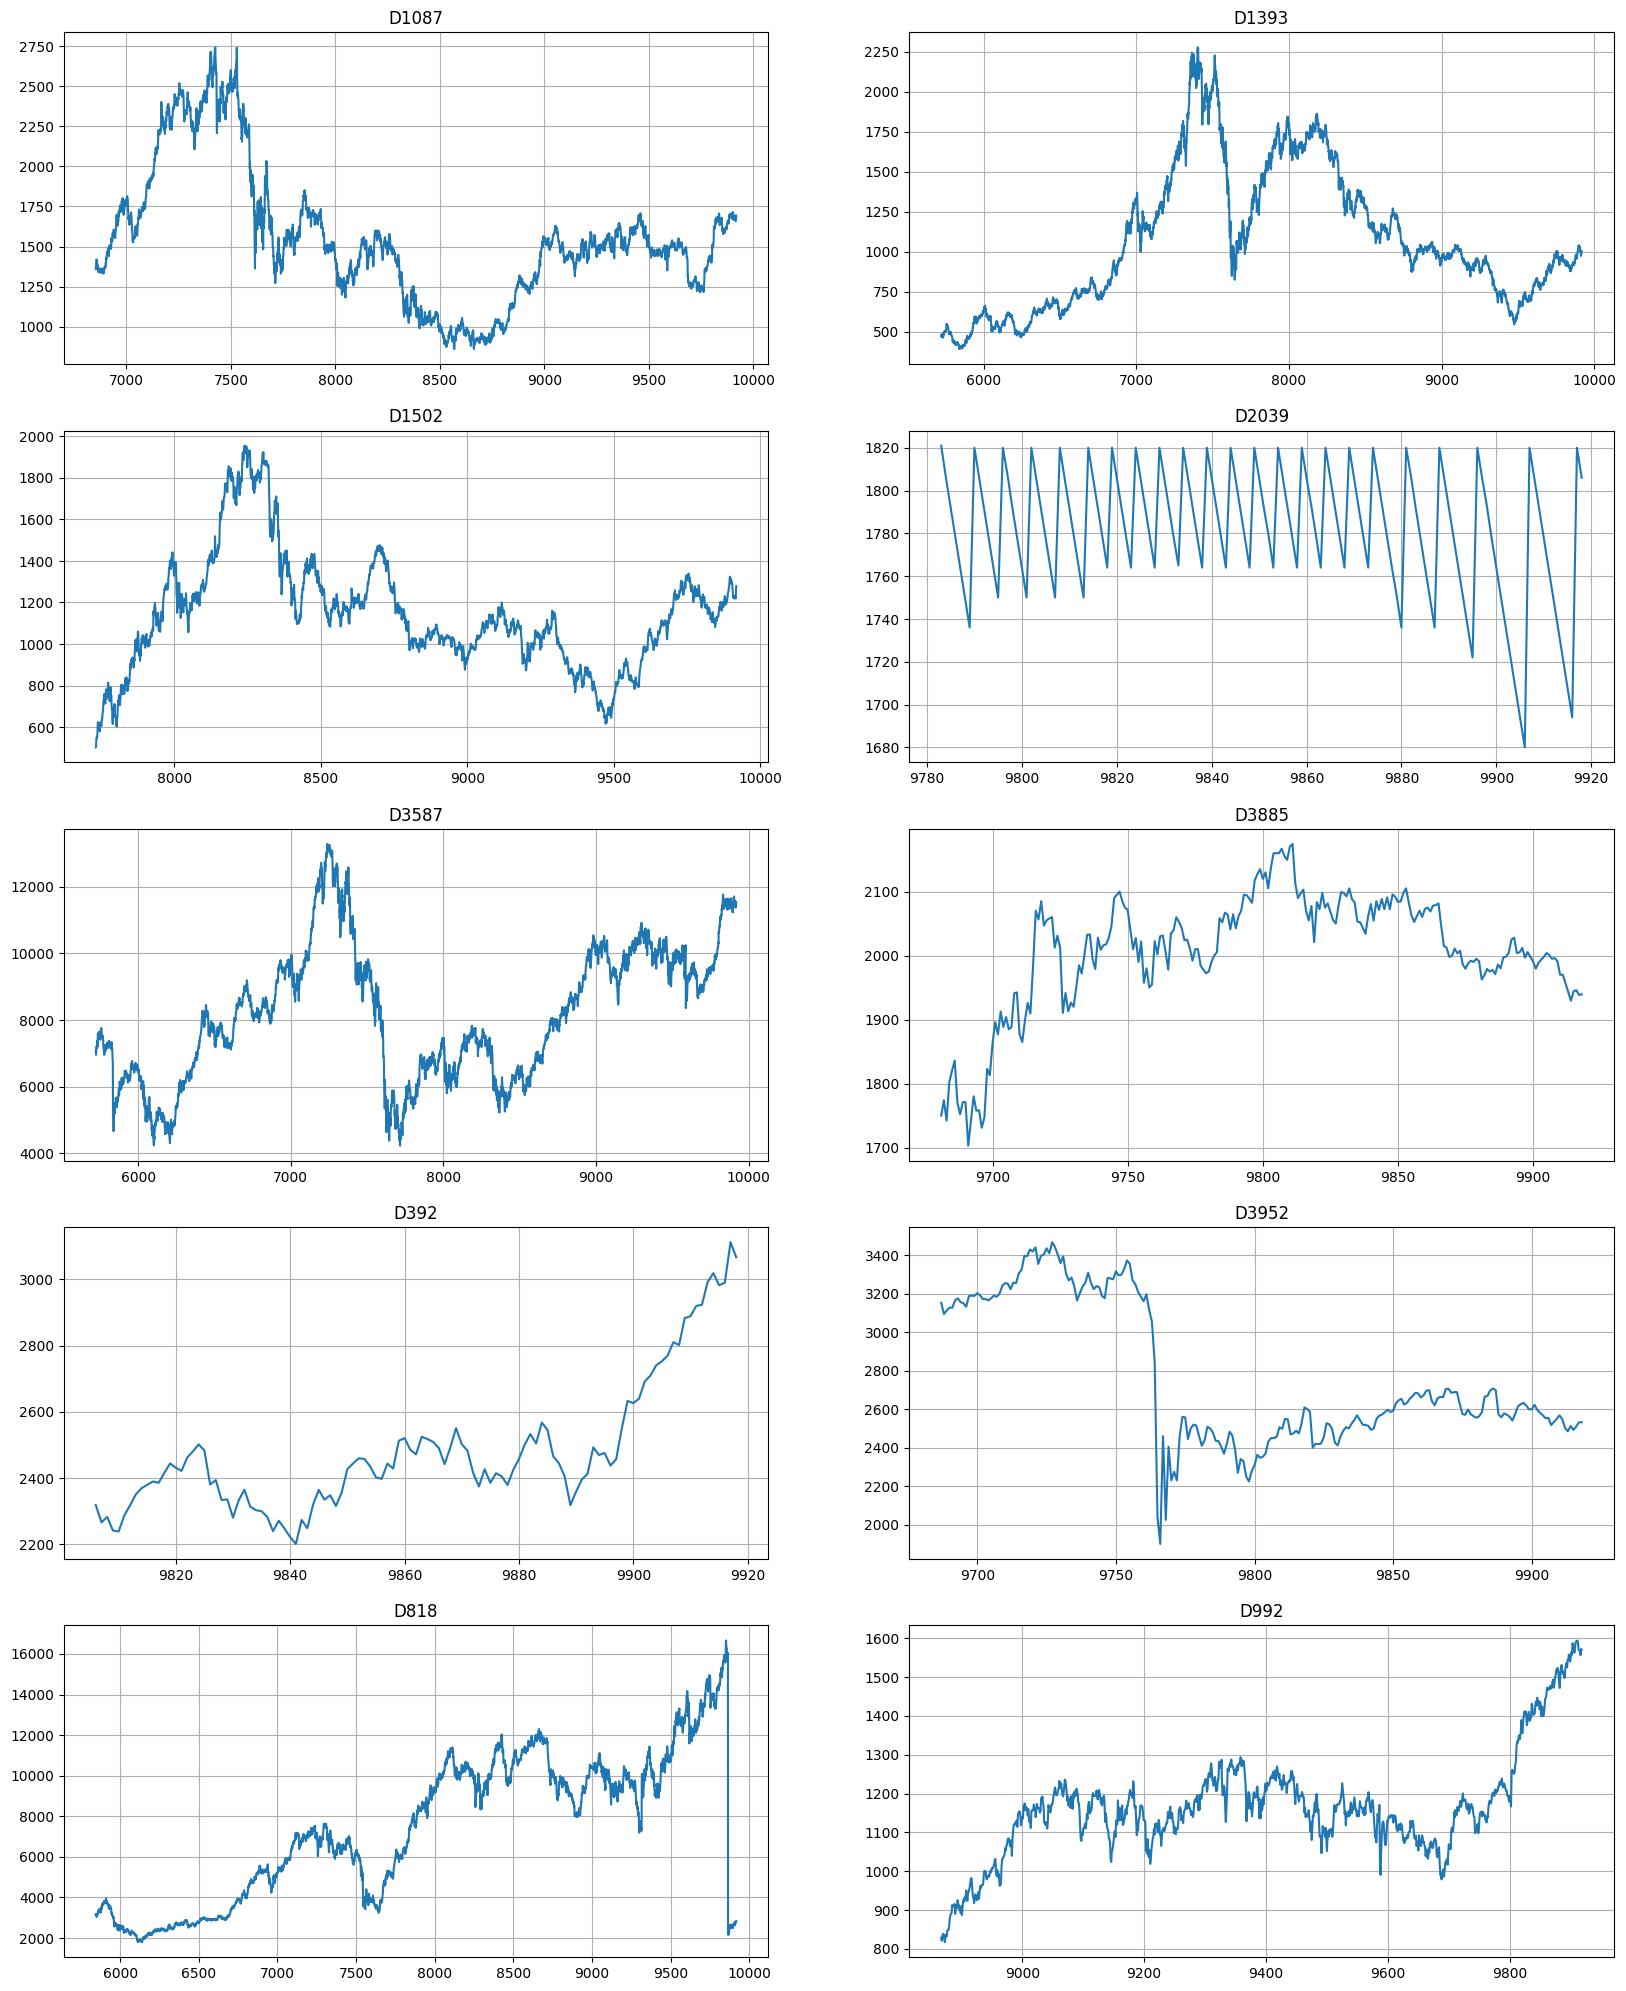

In [25]:
print("Number of segments:", len(ts.segments))
ts.plot(n_segments=10)

Dataset consists of 4k segments of 1-4 years length. As the plot suggests, the behavior of the segments are different across the dataset, and it might be hard to predict all of them accurately. Let's try to evaluate the SMAPE on the backtest using some baseline model.

In [26]:
pipeline = Pipeline(model=NaiveModel(), transforms=[], horizon=30)

It takes about 2 minutes even for naive model to evaluate the performance on this dataset, imagine how long it takes for more complex one.

In [27]:
metrics = pipeline.backtest(ts, metrics=[SMAPE()], n_folds=3, aggregate_metrics=False)["metrics_df"]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.7s


Let's visualize the resulting metrics

In [28]:
from etna.analysis import metric_per_segment_distribution_plot
from etna.analysis import plot_metric_per_segment

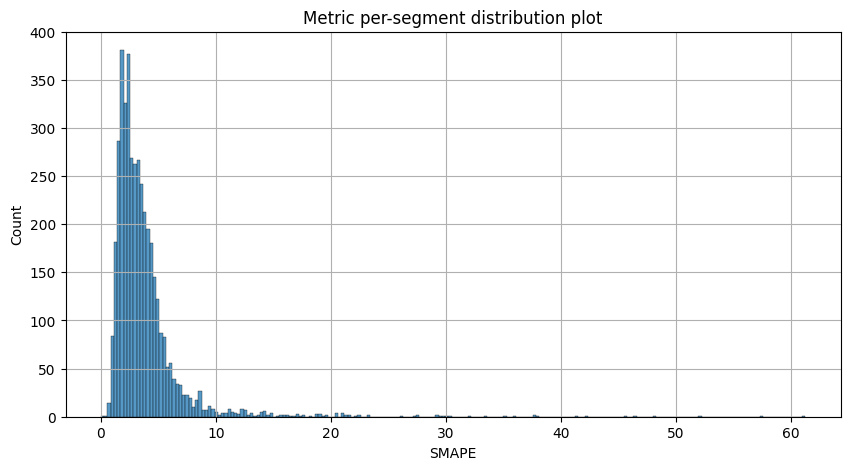

In [29]:
metric_per_segment_distribution_plot(metrics_df=metrics, metric_name="SMAPE", per_fold_aggregation_mode="mean")

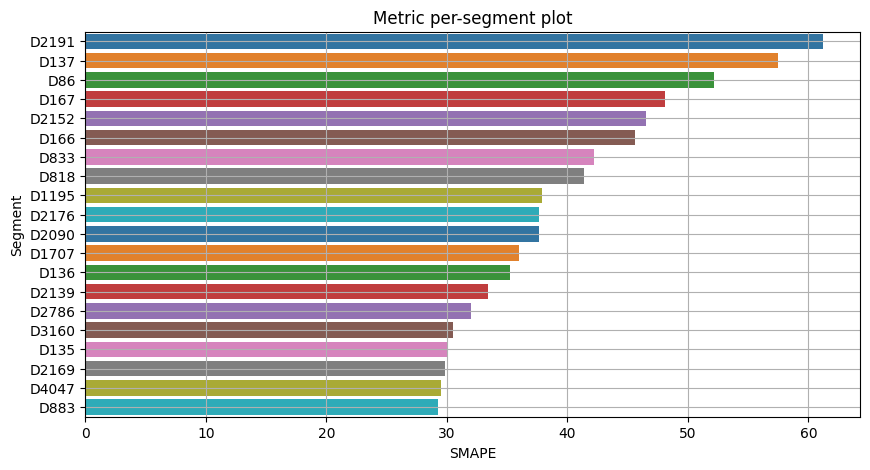

In [30]:
plot_metric_per_segment(metrics_df=metrics, metric_name="SMAPE", top_k=20)

Most of the segments can be forecasted with SMAPE less than 10, however there is a list of segments with SMAPE greater than 20 which we want to catch and analyze separately.

In [31]:
agg_metrics = metrics.groupby("segment").mean().reset_index()
bad_segment_metrics = agg_metrics[agg_metrics["SMAPE"] >= 20]
print(f"Number of bad segments: {len(bad_segment_metrics)}")

Number of bad segments: 42


### 2.2 Loading pretrained analyzer  <a class="anchor" id="section_2_2"></a>

In [32]:
from etna.experimental.classification import PredictabilityAnalyzer

Let's look at the list of available analyzers

In [33]:
PredictabilityAnalyzer.get_available_models()

['weasel', 'tsfresh', 'tsfresh_min']

Pertained analyzer can be loaded from the public s3 bucket by it's name and dataset frequency

In [34]:
PredictabilityAnalyzer.download_model(model_name="weasel", dataset_freq="D", path="weasel_analyzer.pickle")

Once we loaded the analyzer, we can create an instance of it

In [35]:
weasel_analyzer = PredictabilityAnalyzer.load("weasel_analyzer.pickle")

### 2.3 Analyzing segments predictability   <a class="anchor" id="section_2_3"></a>
Now we can analyze the dataset for predictability, which might be done the two ways.

In [36]:
def metrics_for_bad_segments(predictability):
    bad_segments = [segment for segment in predictability if predictability[segment] == 1]
    metrics_for_bad_segments = agg_metrics[agg_metrics["segment"].isin(bad_segments)].sort_values(
        "SMAPE", ascending=False
    )
    print(f"Number of bad segments: {len(metrics_for_bad_segments)}")
    return metrics_for_bad_segments

1. The short way: using `analyze_predictability` method. 

In [37]:
%%time
predictability = weasel_analyzer.analyze_predictability(ts)

CPU times: user 4.67 s, sys: 345 ms, total: 5.02 s
Wall time: 5.01 s


In [38]:
metrics = metrics_for_bad_segments(predictability)

Number of bad segments: 133


2. The long way: using `predict_proba` method. This is more flexible as you can choose the threshold for predictability score.

In [39]:
%%time
series = weasel_analyzer.get_series_from_dataset(ts)
predictability_score = weasel_analyzer.predict_proba(series)

CPU times: user 4.77 s, sys: 333 ms, total: 5.1 s
Wall time: 5.12 s


In [40]:
threshold = 0.4
predictability = {segment: int(predictability_score[i] > threshold) for i, segment in enumerate(sorted(ts.segments))}

In [41]:
metrics = metrics_for_bad_segments(predictability)

Number of bad segments: 406


Let's take a look at the segments with the bad metrics:

In [42]:
metrics.head(10)

,segment,SMAPE,fold_number
412,D137,57.452473,1.0
4072,D86,52.144064,1.0
734,D166,45.620776,1.0
3387,D4047,29.501460,1.0
1310,D2178,29.205434,1.0
4061,D85,22.579621,1.0
1205,D2083,22.547771,1.0
3333,D4,20.994039,1.0
357,D132,15.903925,1.0
2778,D35,14.327464,1.0


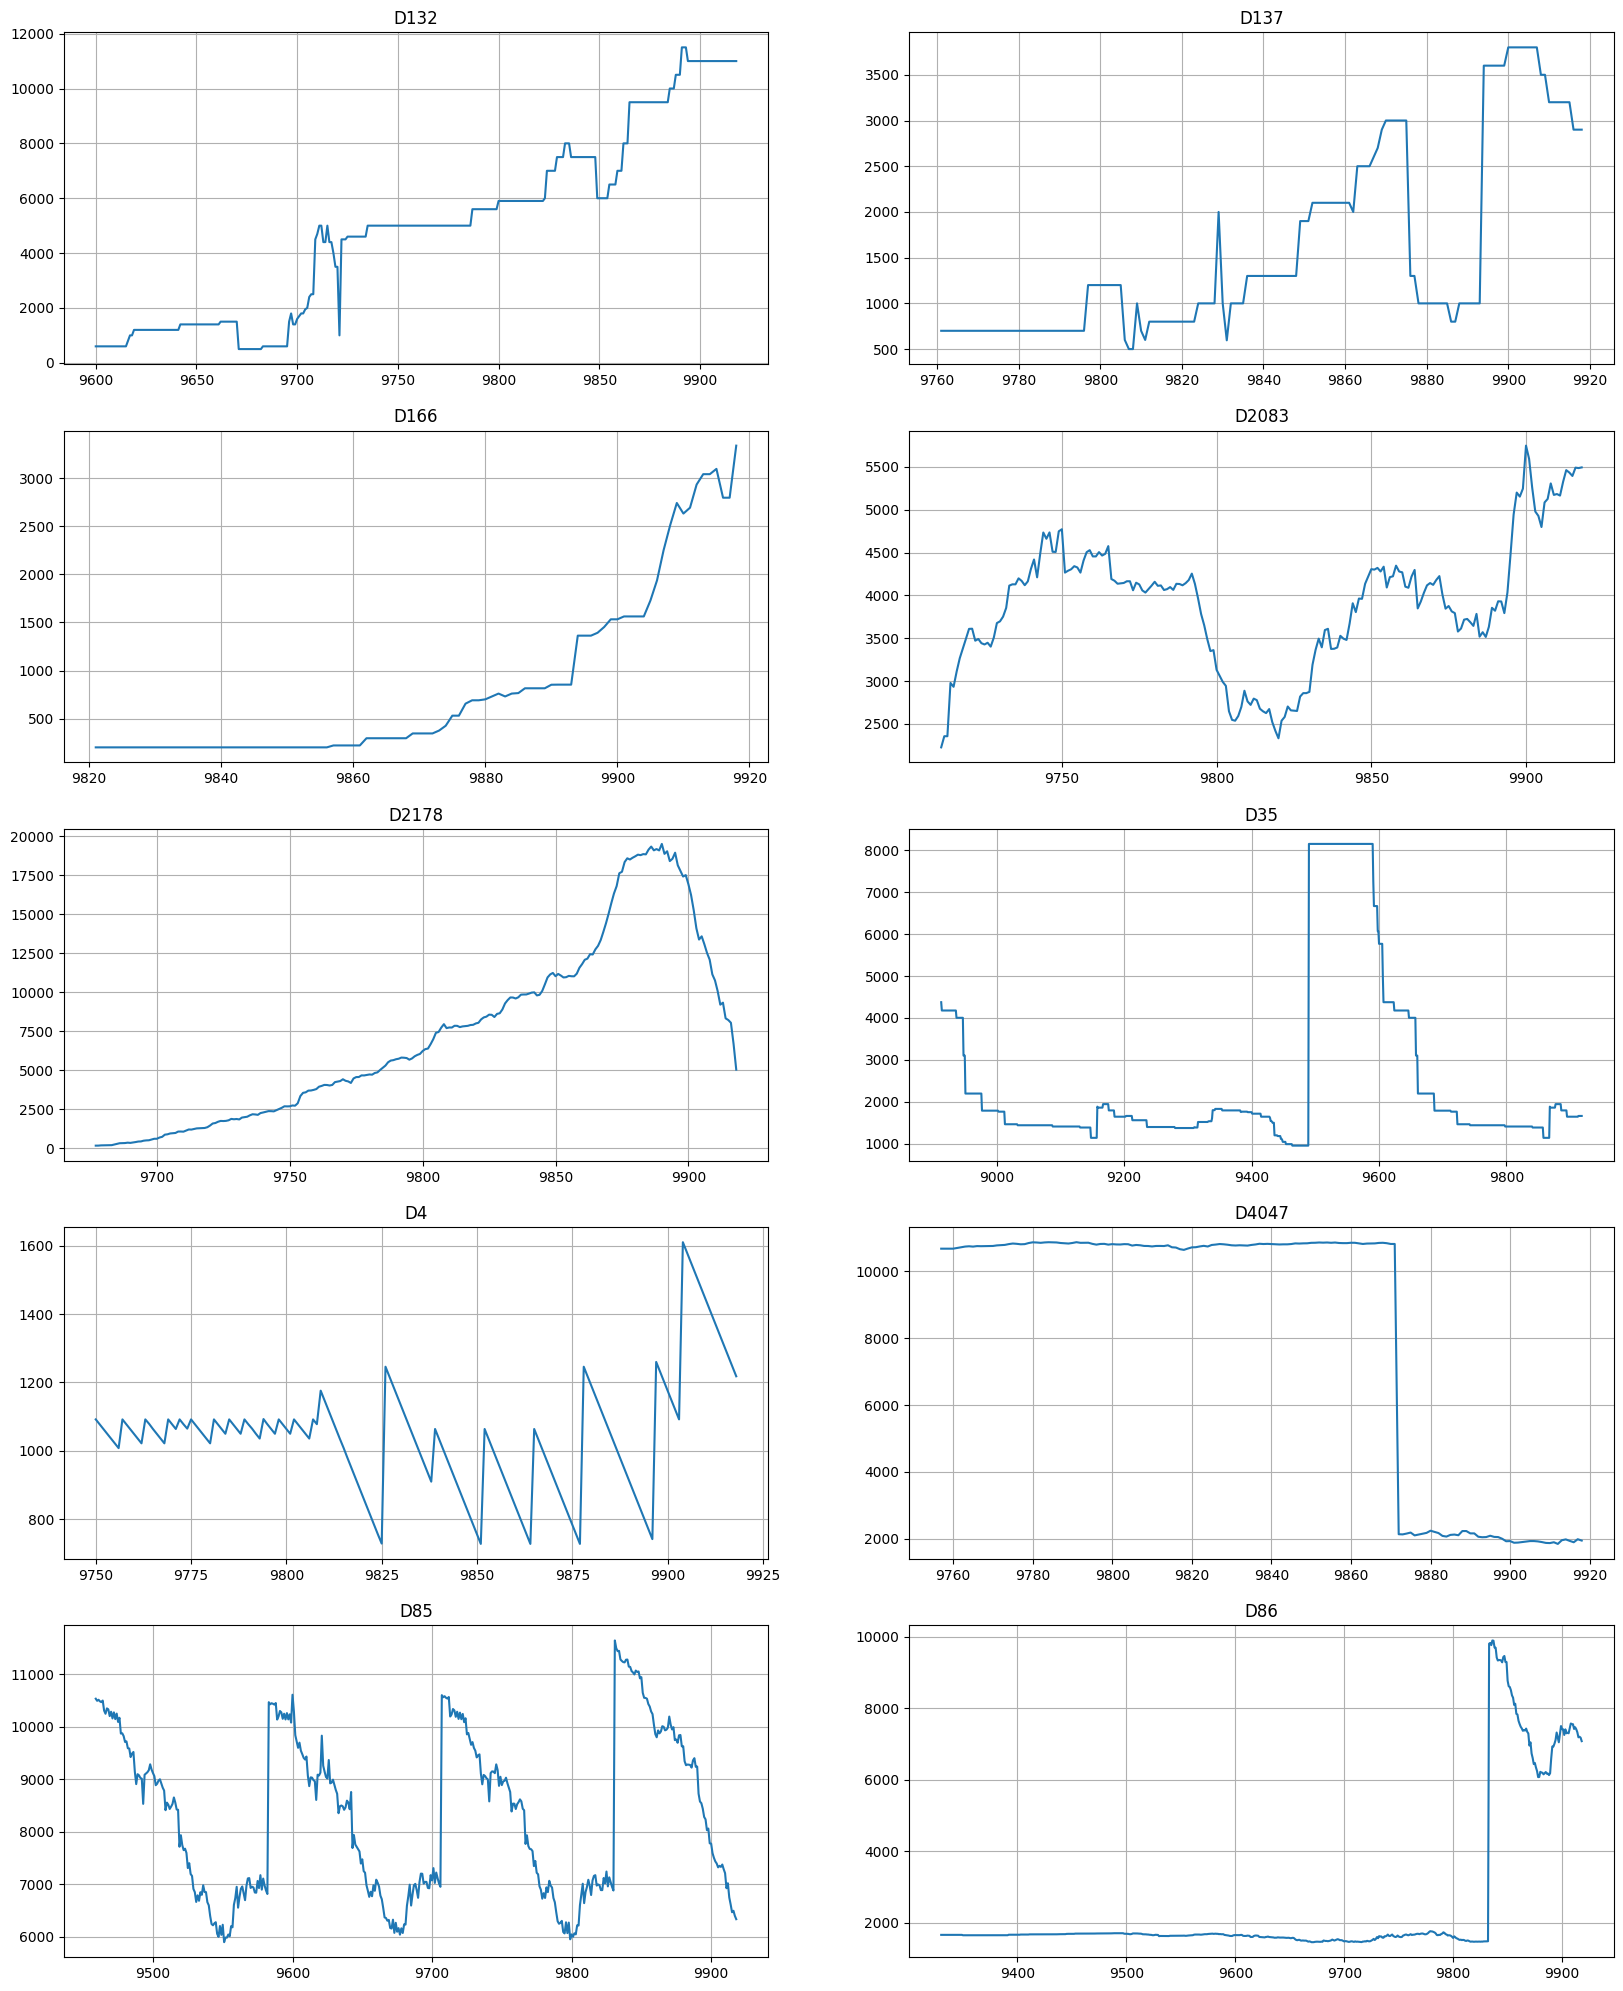

In [43]:
ts.plot(segments=metrics.head(10)["segment"])

It took only about 15 seconds to analyze the dataset and suggest the set of possible bad segments for weasel-based analyzer, which is much faster than using any baseline pipeline.

However, there might be false-positives in the results. 

In [44]:
metrics.tail(10)

,segment,SMAPE,fold_number
1234,D2109,1.387898,1.0
2972,D3674,1.384460,1.0
3706,D53,1.294982,1.0
3534,D418,1.281990,1.0
2167,D295,1.258861,1.0
2457,D321,1.177998,1.0
2446,D320,1.123942,1.0
3242,D3917,1.010831,1.0
346,D131,0.487805,1.0
1348,D2211,0.000000,1.0


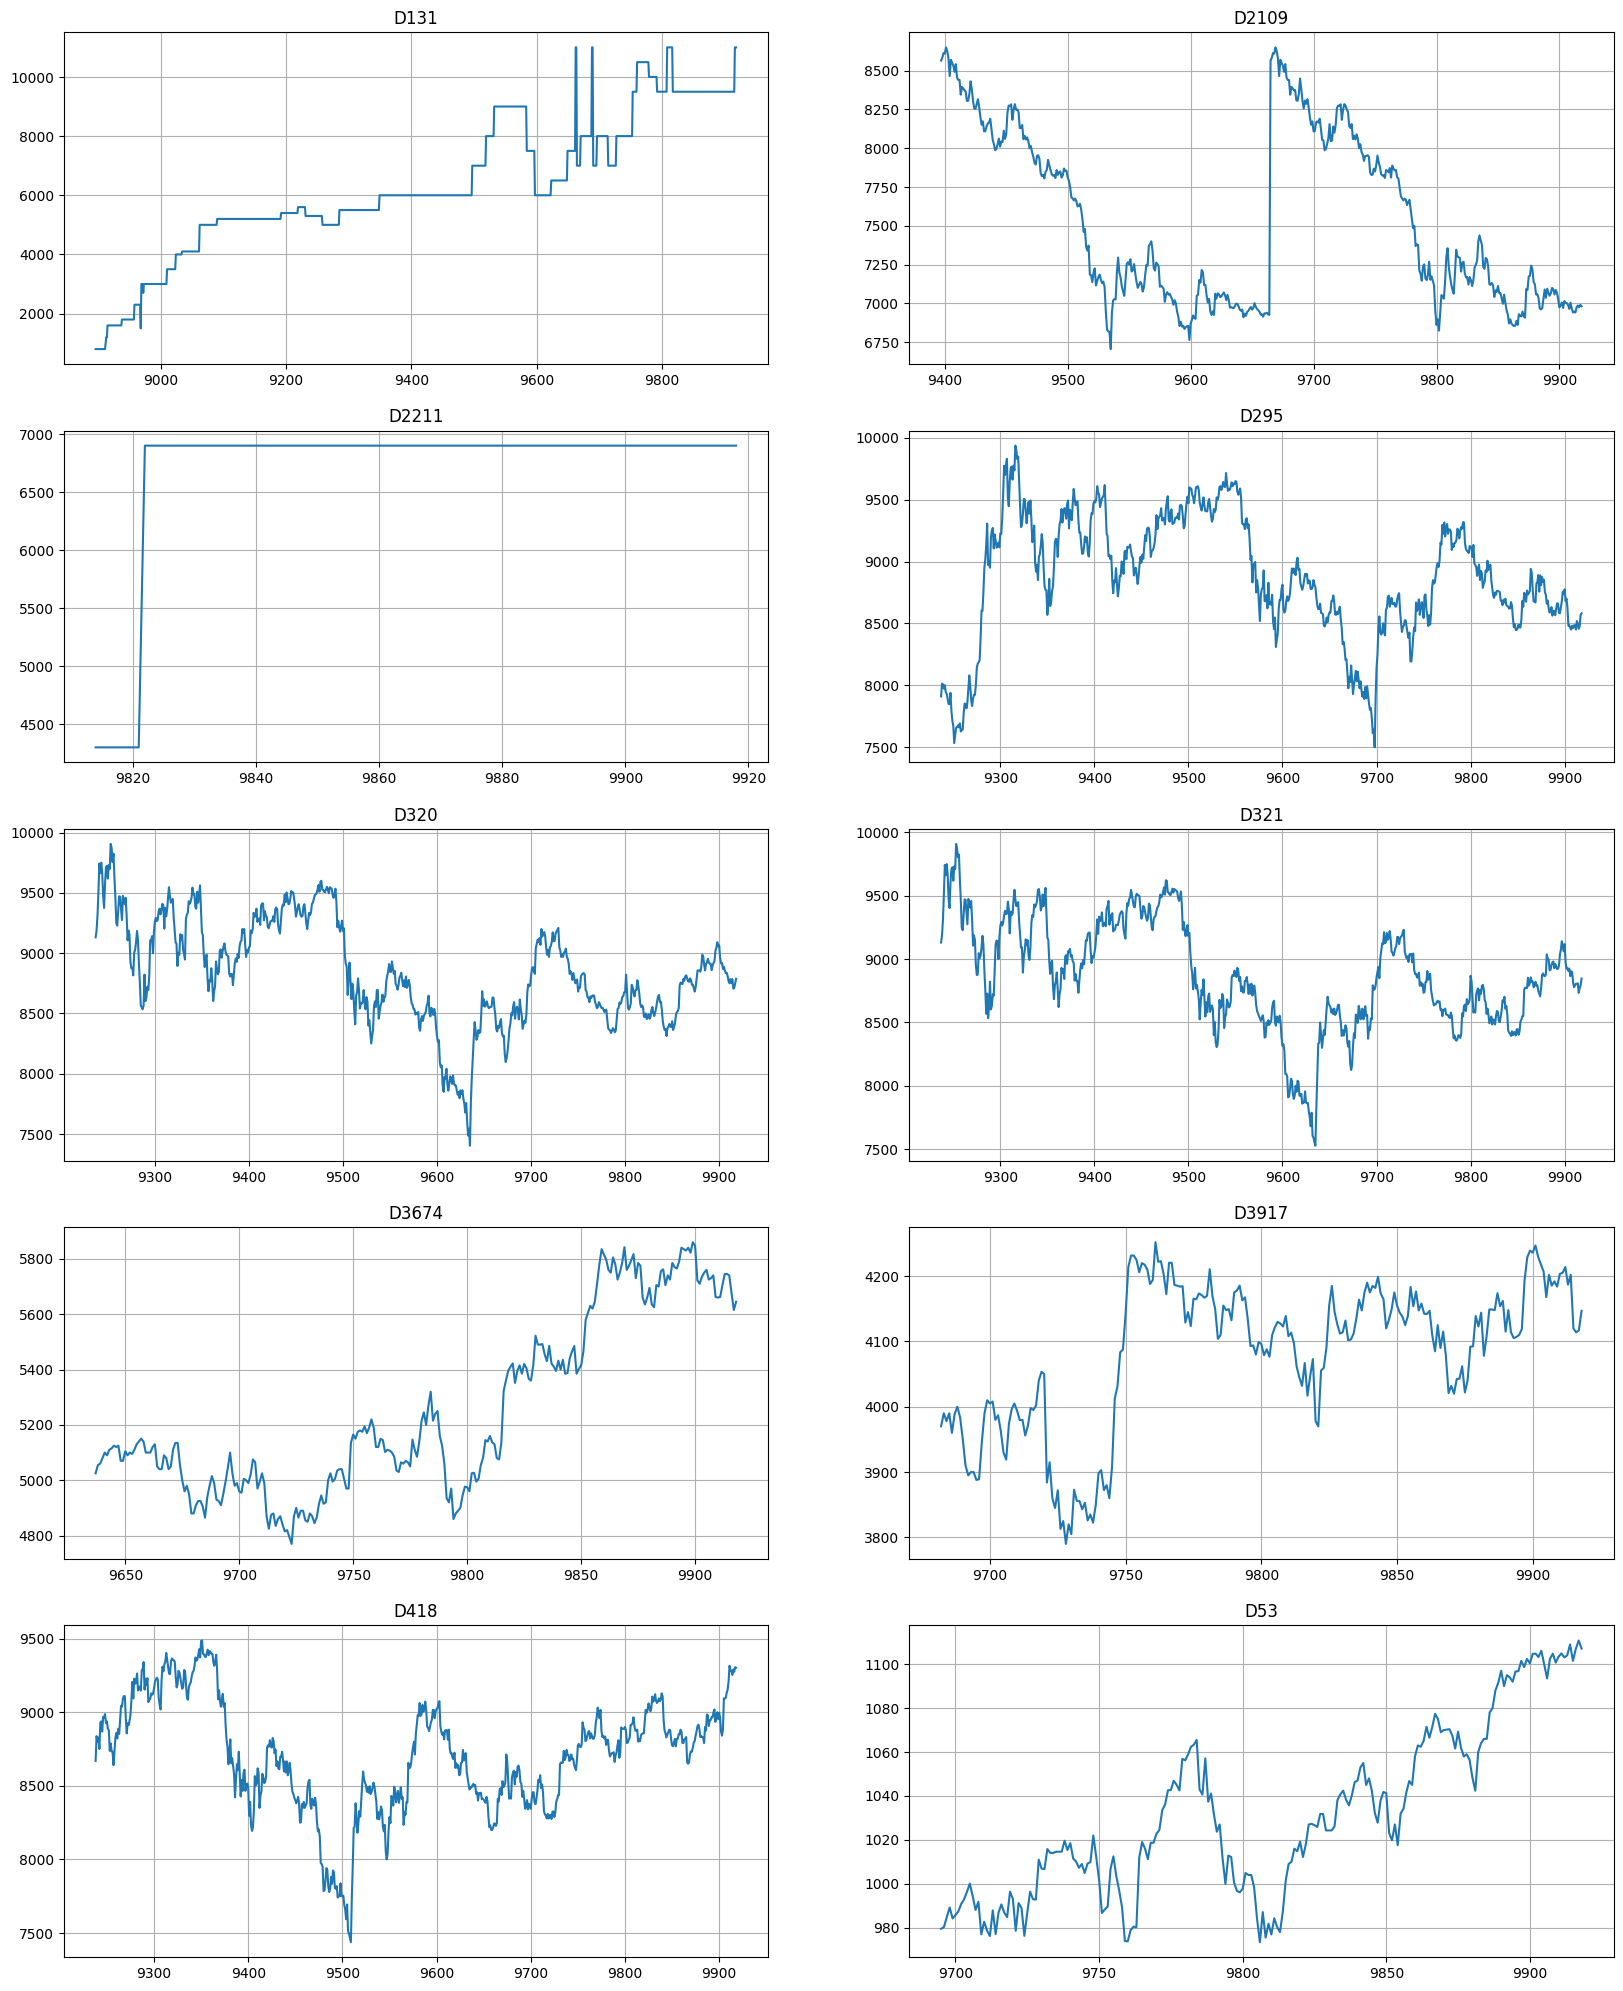

In [45]:
ts.plot(segments=metrics.tail(10)["segment"])

That's all for this notebook. Remember, that this is an experimental feature, and it might change the interface in the future!